In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import re
import os
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Input,Convolution2D,Dropout,LSTM,TimeDistributed,Embedding,Bidirectional,Activation,RepeatVector,Concatenate
from keras.optimizers import adam
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image,sequence
from keras.utils import np_utils
import pickle

In [200]:
images_dir=os.listdir(r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data")
images_path=r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data\Images"
captions_path=r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr8k.token.txt"
train_path=r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt"
val_path=r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.devImages.txt"
test_path=r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt"

In [201]:
captions=open(captions_path,'r').read().split('\n')
x_train=open(train_path,'r').read().split('\n')
x_val=open(val_path,'r').read().split('\n')
x_test=open(test_path,'r').read().split('\n')

In [202]:
tokens={}
for i in range(len(captions)-1):
    x=captions[i].split('#')
    if x[0] in tokens:
        tokens[x[0]].append(x[1][2:])
    else:
        tokens[x[0]]=[x[1][2:]]

In [203]:
tokens['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

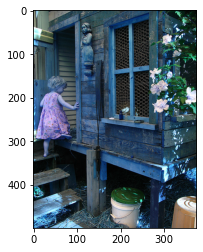

In [204]:
plt.imshow(cv2.imread(images_path+'\\'+'1000268201_693b08cb0e.jpg'))

In [205]:
train_dataset=open(r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data\flickr8ktextfiles\flickr_8k_train_dataset.txt",'wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset=open(r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data\flickr8ktextfiles\flickr_8k_val_dataset.txt",'wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset=open(r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data\flickr8ktextfiles\flickr_8k_test_dataset.txt",'wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [206]:
(x_train[0]+"\t"+'<start>'+tokens[x_train[0]][0]+'<end>'+'\n').encode()

b'2513260012_03d33305cf.jpg\t<start>A black dog is running after a white dog in the snow .<end>\n'

In [207]:
for img in x_train:
    if(img==''):
        continue
    for cap in tokens[img]:
        caption="<start> "+cap+" <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if(img==''):
        continue
    for cap in tokens[img]:
        caption="<start> "+cap+" <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if(img==''):
        continue
    for cap in tokens[img]:
        caption="<start> "+cap+" <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [208]:
train_dataset

<_io.BufferedWriter name='C:\\Users\\Hard Parikh\\Desktop\\flickr8k\\Flickr_Data\\Flickr_Data\\flickr8ktextfiles\\flickr_8k_train_dataset.txt'>

In [209]:
test_dataset

<_io.BufferedWriter name='C:\\Users\\Hard Parikh\\Desktop\\flickr8k\\Flickr_Data\\Flickr_Data\\flickr8ktextfiles\\flickr_8k_test_dataset.txt'>

In [210]:
val_dataset

<_io.BufferedWriter name='C:\\Users\\Hard Parikh\\Desktop\\flickr8k\\Flickr_Data\\Flickr_Data\\flickr8ktextfiles\\flickr_8k_val_dataset.txt'>

In [17]:
from IPython.core.display import display,HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')


94658560/94653016 [==============================] - 465s 5us/step


In [18]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [63]:
def preprocessing(img_path):
    im=image.load_img(img_path,target_size=(224,224,3))
    im=image.img_to_array(im)
    im=np.expand_dims(im,axis=0)
    return im

In [66]:
train_data={}
ctr=0
for img in x_train:
    if(img==''):
        continue
    if(ctr>=3000):
        break
    ctr=ctr+1
    if(ctr%1000==0):
        print(ctr)
    path=images_path+'\\'+img
    img_=preprocessing(path)
    pred=model.predict(img_).reshape(2048)
    train_data[img]=pred


1000
2000
3000


In [494]:
len(train_data)

3000

In [212]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )

In [213]:
pd_dataset=pd.read_csv(r"C:\Users\Hard Parikh\Desktop\flickr8k\Flickr_Data\Flickr_Data\flickr8ktextfiles\flickr_8k_train_dataset.txt",delimiter='\t')

In [214]:
pd_dataset
ds=pd_dataset.values

In [215]:
ds.shape

(30000, 2)

In [216]:
ds[0][1]

'<start> A black dog is running after a white dog in the snow . <end>'

In [217]:
sentences=[]
for i in ds:
    x=i[1]
    sentences.append(x)

In [218]:
len(sentences)

30000

In [219]:
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [220]:
words=[i.split() for i in sentences]

In [221]:
len(words)

30000

In [222]:
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [223]:
len(unique)

8253

In [224]:
unique

['Buddha',
 'watch',
 'interested',
 'Watching',
 'dove',
 'hit',
 'wavy',
 'rainy',
 'telegraph',
 'wide-legged',
 'unifrom',
 'participates',
 'red-seated',
 'starlet',
 'medium-sized',
 'position',
 'somehow',
 'ashen',
 'peddal',
 'tumbling',
 'histerically',
 'hi',
 '10',
 'jumpsuits',
 'create',
 'tutu',
 'cannonball',
 'biking',
 'portrate',
 'file',
 'helmeted',
 'based',
 'outfitted',
 'visible',
 'breezeway',
 'glide',
 'points',
 'driven',
 'aiming',
 'straw',
 'wrestlers',
 '<start>',
 'paisley',
 'catches',
 'waterproofs',
 'chiseling',
 'reacts',
 'expressions',
 'returns',
 'blays',
 'cleavage',
 'Pokemon',
 'thing',
 'bearer',
 'arguing',
 'nursing',
 'Grand',
 'sled',
 'nursery',
 'breaks',
 'steam',
 'rapid',
 'roofed',
 'Sheperd',
 'amuseument',
 'downpour',
 'tire',
 'bluejean',
 'kneeling',
 'bundled-up',
 'grotto',
 'grounded',
 'marches',
 'gentle',
 'cowboy',
 'Clause',
 'peddled',
 'city',
 'shack',
 'Indians',
 'tap',
 'encouraging',
 'm',
 'daisies',
 'guidew

In [225]:
word_2_indices={j:i for i,j in enumerate(unique)}

In [226]:
word_2_indices={j:i for i,j in enumerate(unique)}
indices_2_word={i:j for i,j in enumerate(unique)}

In [227]:
word_2_indices['<end>']

865

In [228]:
word_2_indices['UNK']=0
word_2_indices['raining']=8253

In [229]:
indices_2_word[0]='UNK'

In [230]:
indices_2_word[8253]='raining'

In [231]:
word_2_indices['<start>']

41

In [232]:
vocab_size=len(word_2_indices.keys())

In [233]:
vocab_size

8254

In [234]:
length=[]
for i in sentences:
    x=i.split()
    x=len(x)
    length.append(x)

In [235]:
max_len=max(length)

In [236]:
sentences[0]

'<start> A black dog is running after a white dog in the snow . <end>'

In [238]:
max_len

40

In [259]:
padded_sequences=[]
subsequent_words=[]
for i in range(ds.shape[0]):
    partial_seq=[]
    next_word=[]
    text=ds[i,1].split()
    text=[word_2_indices[i] for i in text]
    for i in range(1,len(text)):
        partial_seq.append(text[:i])
        next_word.append(text[i])
    padded_partial_seq=sequence.pad_sequences(partial_seq,max_len,padding='post')
    next_word_1hot=np.zeros([len(next_word),vocab_size],dtype=np.bool)
    
    for i,next_word in enumerate(next_word):
        next_word_1hot[i,next_word]=1
        
    padded_sequences.append(padded_partial_seq)
    subsequent_words.append(next_word_1hot)
padded_sequences=np.asarray(padded_sequences)
subsequent_words=np.asarray(subsequent_words)

In [260]:
padded_sequences.shape

(30000,)

In [261]:
subsequent_words.shape

(30000,)

In [262]:
padded_sequences[0]

array([[  41,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  41, 7660,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  41, 7660, 7446,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  41, 7660, 7446, 7128,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  

In [267]:
for i in range(len(padded_sequences[0])):
    for j in range(max_len):
        print(indices_2_word[padded_sequences[0][i][j]],)
    print('\n')
print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [270]:
subsequent_words[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [275]:
num_of_images=2000
captions=np.zeros([0,max_len])
next_words=np.zeros([0,vocab_size])

In [276]:
for i in range(num_of_images):
    captions=np.concatenate([captions,padded_sequences[i]])
    next_words=np.concatenate([next_words,subsequent_words[i]])

In [277]:
print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [278]:
np.save('captions.py',captions)
np.save('next_words.py',next_words)

In [289]:
captions.shape

(25493, 40)

In [290]:
with open('train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [304]:
imgs=[]
for i in range(ds.shape[0]):
    if(ds[i,0] in encoded_images.keys()):
        imgs.append(list(encoded_images[ds[i,0]]))

In [309]:
imgs=np.asarray(imgs)

In [310]:
imgs.shape

(15000, 2048)

In [311]:
images=[]
for i in range(num_of_images):
    for j in range(padded_sequences[i].shape[0]):
        images.append(imgs[i])

In [313]:
images=np.asarray(images)

In [314]:
images.shape

(25493, 2048)

In [319]:
image_names=[]
for i in range(num_of_images):
    for j in range(padded_sequences[i].shape[0]):
        image_names.append(ds[i,0])

In [320]:
# image_names=np.asarray(image_names)

In [322]:
len(image_names)

25493

In [323]:
imag=image_names

In [324]:
embedding_size=128
max_len=40

In [325]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [326]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [327]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1056512     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      dense_1_input[0][0]              
____________________________________________________________________________________________

In [330]:
print(image_model.output)
print(language_model.output)

Tensor("repeat_vector_1/Tile:0", shape=(?, 40, 128), dtype=float32)
Tensor("time_distributed_1/Reshape_1:0", shape=(?, 40, 128), dtype=float32)


In [342]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=200)

Epoch 1/200
25493/25493 [==============================] - 101s 4ms/step - loss: 5.6787 - accuracy: 0.0834
Epoch 2/200
25493/25493 [==============================] - 96s 4ms/step - loss: 5.1102 - accuracy: 0.1373
Epoch 3/200
25493/25493 [==============================] - 96s 4ms/step - loss: 4.9111 - accuracy: 0.1643
Epoch 4/200
25493/25493 [==============================] - 98s 4ms/step - loss: 4.7223 - accuracy: 0.1909
Epoch 5/200
25493/25493 [==============================] - 100s 4ms/step - loss: 4.5106 - accuracy: 0.2294
Epoch 6/200
25493/25493 [==============================] - 102s 4ms/step - loss: 4.3930 - accuracy: 0.2401
Epoch 7/200
25493/25493 [==============================] - 102s 4ms/step - loss: 4.3242 - accuracy: 0.2418
Epoch 8/200
25493/25493 [==============================] - 102s 4ms/step - loss: 4.2506 - accuracy: 0.2501
Epoch 9/200
25493/25493 [==============================] - 104s 4ms/step - loss: 4.1875 - accuracy: 0.2551
Epoch 10/200
25493/25493 [==============

In [343]:
images[0]

array([0.30808365, 0.812914  , 0.28417176, ..., 0.25810206, 0.        ,
       0.21858194], dtype=float32)

In [344]:
captions[0]

array([41.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.])

In [345]:
next_words[0].shape

(8254,)

In [8]:
# model.save_weights("model_weights.h5")
import numpy as np
model=np.load("model_weights.h5",allow_pickle=True)

OSError: Failed to interpret file 'model_weights.h5' as a pickle

In [348]:
def preprocessing(img_path):
    img=image.load_img(img_path,target_size=(224,224,3))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    return img

In [349]:
def get_encoding(model,img):
    image=preprocessing(img)
    pred=model.predict(image).reshape(2048)
    return pred

In [350]:
resnet=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [1]:
img=r"C:\Users\Hard Parikh\Anaconda3\envs\tf_gpu\Lib\site-packages\object_recognition_detection\test_images\image2.jpg"

In [2]:
plt.imshow(cv2.imread(img))

NameError: name 'plt' is not defined

In [522]:
test_img=get_encoding(resnet,img)

In [523]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
                    

        if word_pred == "<end>" or len(start_word) > max_len:
            break
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

Two bald girls are shown behind the water in a vehicle vehicle plastic balls .


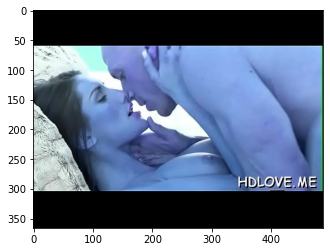

In [524]:
plt.imshow(cv2.imread(img))
print(Argmax_Search)

6.125